In [2]:
# !pip install virtualenv --user

In [3]:
# !python3 -m venv demo-env

In [4]:
# !demo-env\Scripts\activate.bat

In [5]:
# !pip search sklearn

In [6]:
# !pip install scikit-learn --user

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sys

In [98]:
from sklearn.svm import SVR,SVC
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import AdaBoostRegressor
#Import Feature Selection tools
from sklearn.feature_selection import RFE
from sklearn.feature_selection import SelectKBest, f_regression

from random import random, randint
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split  
from sklearn import neighbors
from imblearn.over_sampling import ADASYN
from imblearn.over_sampling import (SMOTE, BorderlineSMOTE, SVMSMOTE, SMOTENC,
                                    KMeansSMOTE)

In [3]:
from warnings import simplefilter,filterwarnings
from sklearn.exceptions import DataConversionWarning
simplefilter(action='ignore',category = FutureWarning)
simplefilter(action='ignore',category = RuntimeWarning)
filterwarnings(action='ignore',category=DataConversionWarning)
import pandas as pd
pd.options.mode.chained_assignment = None 

### 12/07

In [4]:
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import KBinsDiscretizer
from sklearn import preprocessing

In [5]:
# 1
raw_data = pd.read_csv("corn_data.csv")
X = raw_data.iloc[:,1:-1]
y = raw_data.iloc[:,-1:]
y_extd = y.copy()

n_bins = 5
binner_qtl = KBinsDiscretizer(n_bins=n_bins, encode='ordinal',strategy='quantile')
binner_km = KBinsDiscretizer(n_bins=n_bins, encode='ordinal',strategy='kmeans')
binner_uni= KBinsDiscretizer(n_bins=n_bins, encode='ordinal',strategy='uniform')

y_extd.loc[:,"class_uniform"] = binner_uni.fit_transform(np.array(y_extd["output"]).reshape(264,1))
y_extd.loc[:,"class_quantile"] = binner_qtl.fit_transform(np.array(y_extd["output"]).reshape(264,1))
y_extd.loc[:,"class_kmeans"] = binner_km.fit_transform(np.array(y_extd["output"]).reshape(264,1))

In [6]:
y_extd.head()

,output,class_uniform,class_quantile,class_kmeans
0,2.516485,2.0,3.0,2.0
1,1.640909,1.0,1.0,1.0
2,0.416348,0.0,0.0,0.0
3,1.338558,1.0,1.0,1.0
4,1.729517,1.0,1.0,1.0


In [7]:
def make_bins(data,bin_edges):
    newList = []
    for num in data:
        i = 0;
        while i < len(bin_edges) and num >= bin_edges[i]:
            i+=1
        newNum = bin_edges[max(0,i-1)]
        newList.append(newNum)
    return newList

def find_neighbors_mean_y(X,y,X_res,n_neighbors):
    NN_obj = NearestNeighbors(n_neighbors = n_neighbors)
    NN_obj.fit(X)
    resampled_set_neighbors_list = NN_obj.kneighbors(X_res,n_neighbors)
    y_neighbors = np.array([[y.loc[each_neighbor,"output"] for each_neighbor in each_data] for each_data in resampled_set_neighbors_list[1]])
    neighbors_mean_y_list = np.array([np.mean(each_list) for each_list in y_neighbors]).reshape(len(y_neighbors),1)
    return neighbors_mean_y_list

In [11]:
# class_col = "class_uniform"
# X_train_cls, X_test_cls, y_train_cls, y_test_cls = train_test_split(X,y_extd,stratify=y_extd[class_col])


# def generate_synthetic_data(X_train,y_train,class_col,n_neighbors, pure_synthetic):
#     sm = SMOTE()
#     X_res, y_res = sm.fit_resample(X_train,y_train[class_col])

#     synthetic_data = pd.DataFrame()
#     for i in range(5):
#         y_i = y_train[y_train[class_col] == 1][class_col] # Get all y that is in bin i'th
#         X_i = X.loc[y_i.index]         # Get all the corresponding X's in the train set
#         X_res_bin_i = X_res.loc[pd.Series.where(y_res,y_res==i).dropna().index] # Find all synthetic data that falls into that bin
        
#         KNN = NearestNeighbors(n_neighbors = n_neighbors)
#         KNN.fit(X_i)
#         X_resampled_same_bin_neighbors_list = KNN.kneighbors(X_res_bin_i,n_neighbors=n_neighbors) # Find in train set the nearest neighbor to each resampled data
        
#         y_neighbors_distances = np.array(X_resampled_same_bin_neighbors_list[0])
#         y_train_index = [[y_i.index[i] for i in each_data] for each_data in X_resampled_same_bin_neighbors_list[1]]
        
#         y_neighbors = np.array([[y_i.loc[each_neighbor,"output"] for each_neighbor in each_data] for each_data in y_train_index])
#         neighbors_mean_distances = np.array([np.mean(each_list) for each_list in y_neighbors_distances]).reshape(len(y_neighbors_distances),1)
#         neighbors_mean_y_list = np.array([np.mean(each_list) for each_list in y_neighbors]).reshape(len(y_neighbors),1)
# #         X_res_bin_i.loc[:,"output"]=neighbors_mean_y_list
#         synthetic_data = synthetic_data.append(X_res_bin_i)
        
#     if pure_synthetic:
#         train_data = X_train.copy()
#         train_data.loc[:,"output"] = y_train["output"]
#         synthetic_data.append(train_data)
#         synthetic_data.index = [i for i in range(len(synthetic_data))]
# #         X_syn = 
#         synthetic_data = synthetic_data.drop_duplicates(subset=[i for i in range(1135)],keep=False)

#     return synthetic_data,neighbors_mean_y_list 

# generate_synthetic_data(X_train_cls,y_train_cls,class_col,n_neighbors=2, pure_synthetic=False)


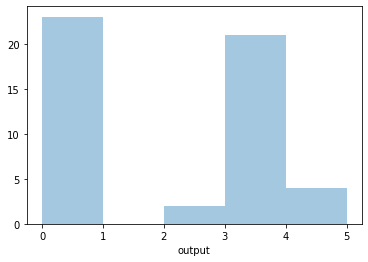

In [47]:
class_col = "class_uniform"
n_neighbors= 2
X_train_cls, X_test_cls, y_train_cls, y_test_cls = train_test_split(X,y_extd,stratify=y_extd[class_col],random_state = 1)
pure_synthetic=True

def generate_synthetic(X,y,class_col,pure_synthetic):
    X_train, X_test, y_train, y_test = train_test_split(X,y,stratify=y_train_cls[class_col],random_state = 1)
    synthetic_data = pd.DataFrame()
    for i in range(5):
        sm = SMOTE(sampling_strategy = "all",random_state=1)
        X_res, y_res = sm.fit_resample(X_train,y_train[class_col])

        # Extract each bin of synthetic data
        y_res_i = y_res[y_res==i]
        X_res_i = X_res.loc[y_res_i.index]

        # Extract the original data in the same bin
        y_i = y_train[y_train[class_col] == i][class_col]
        X_i = X.loc[y_i.index]

        # Fit on the original data and use it to predict the synthetic ones
        KNN = NearestNeighbors(n_neighbors = n_neighbors)
        KNN.fit(X_i)
        neighbors_index_list = KNN.kneighbors(X_res_i,n_neighbors=n_neighbors)[1]
        mean_list = [np.mean(y_train.loc[y_i.iloc[neighbors_index_list[j]].index,"output"]) for j in range(len(neighbors_index_list))]    
        X_res_i.loc[:,"output"] = mean_list

        synthetic_data = synthetic_data.append(X_res_i)

    if pure_synthetic:
        indexes = synthetic_data.iloc[:,:-1].append(X_train).drop_duplicates(keep=False).index
    else:
        indexes = synthetic_data.iloc[:,:-1].append(X_train).drop_duplicates(keep="first").index
    return synthetic_data.loc[indexes],X_train, X_test, y_train, y_test


synthetic_data,X_train, X_test, y_train, y_test = generate_synthetic(X_train_cls,y_train_cls,class_col,pure_synthetic=True)
synthetic_data
sns.distplot(synthetic_data["output"],bins=[0,1,2,3,4,5],hist=True,kde=False)




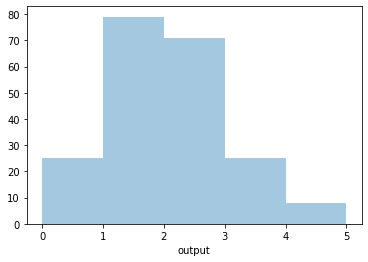

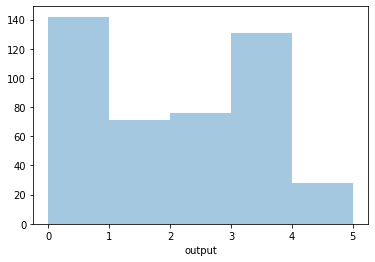

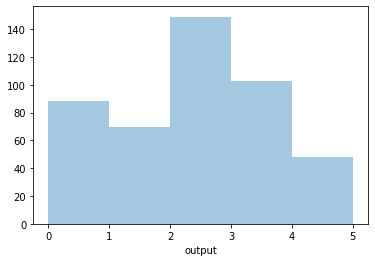

In [65]:
class_col = "class_uniform"
n_neighbors= 2
pure_synthetic=True
iterations = 5

for class_col in ["class_quantile","class_uniform","class_kmeans"]:
    synthetic_data = pd.DataFrame([])
    X_train_cls, X_test_cls, y_train_cls, y_test_cls = train_test_split(X,y_extd,stratify=y_extd[class_col],random_state = 1)
    for j in range(iterations):    
        synthetic_data_j,X_train, X_test, y_train, y_test = generate_synthetic(X_train_cls,y_train_cls,class_col,pure_synthetic=True)
        synthetic_data = synthetic_data.append(synthetic_data_j)
    train_data = raw_data.loc[X_train_cls.index]
    synthetic_data = synthetic_data.append(train_data)
    sns.distplot(synthetic_data["output"],bins=[0,1,2,3,4,5],hist=True,kde=False)
    plt.show()

    


In [89]:
class_col = "class_uniform"
n_neighbors= 2
X_train_cls, X_test_cls, y_train_cls, y_test_cls = train_test_split(X,y_extd,stratify=y_extd[class_col],random_state = 1)

X_train, X_test, y_train, y_test = train_test_split(X_train_cls,y_train_cls,stratify=y_train_cls[class_col],random_state = 1)
# raw_data.loc[X_train.index].iloc[:,1:]
synthetic_data = pd.DataFrame()
sm = SMOTE(sampling_strategy = "all",random_state=1)
X_res, y_res = sm.fit_resample(X_train,y_train[class_col])

for i in range(5):
    # Extract each bin of synthetic data
    y_res_i = y_res[y_res==i]
    X_res_i = X_res.loc[y_res_i.index]

    # Extract the original data in the same bin
    y_i = y_train[y_train[class_col] == i][class_col]
    X_i = X.loc[y_i.index]

    # Fit on the original data and use it to predict the synthetic ones
    KNN = NearestNeighbors(n_neighbors = n_neighbors)
    KNN.fit(X_i)
    neighbors_index_list = KNN.kneighbors(X_res_i,n_neighbors=n_neighbors)[1]
    mean_ouput_list = [np.mean(y_train.loc[y_i.iloc[neighbors_index_list[j]].index,"output"]) for j in range(len(neighbors_index_list))]    
    X_res_i.loc[:,"output"] = mean__output_list

    synthetic_data = synthetic_data.append(X_res_i)


# X_res, y_res = sm.fit_resample(X_train,y_train[class_col])
# X_res = X_res.append(X_train).drop_duplicates(keep=False)
# y_res = y_res.loc[X_res.index]


# X_res = X_res.append(X_train)
# y_res = y_res.append(y_train[class_col])
# X_res.index = y_res.index =  range(len(X_res))


# sns.distplot(y_res,bins=[0,1,2,3,4,5],hist=True,kde=False)
# plt.show()
synthetic_data

# svr_j = SVR(kernel='rbf',degree=1,gamma='scale',coef0=-50,tol=0.01,C=5,epsilon=0.1,
#       shrinking=True,cache_size=50,verbose=False)
# svr_j.fit(X_res,y_res) 

# y_test_pred = svr_j.predict(X_test_cls)

# r2_test_j = r2_score(y_test_pred['output'],y_test_j_pred)


# y_res = y_res.loc[X_train.index]

,0,1,2,3,4,5,6,7,8,9,...,1126,1127,1128,1129,1130,1131,1132,1133,1134,output
8,1,-1,1,1,-1,-1,1,1,1,1,...,-1,1,-1,1,-1,-1,-1,1,0,0.859912
16,1,1,1,0,-1,-1,1,-1,1,-1,...,-1,1,-1,1,-1,-1,-1,1,0,0.805717
24,1,1,1,0,-1,-1,1,-1,-1,-1,...,-1,0,-1,-1,-1,-1,-1,1,0,0.832023
26,1,1,1,1,-1,-1,1,1,-1,-1,...,-1,1,0,-1,1,-1,-1,1,0,0.867448
40,1,1,1,-1,-1,1,1,-1,1,-1,...,-1,0,-1,1,1,-1,-1,1,-1,0.470682
44,1,-1,1,1,-1,-1,1,1,1,-1,...,-1,1,-1,-1,1,-1,-1,1,0,0.664926
47,1,-1,-1,-1,-1,-1,1,-1,-1,-1,...,-1,1,-1,-1,1,-1,-1,-1,0,0.442654
49,1,1,1,1,-1,-1,1,-1,-1,1,...,-1,1,-1,-1,-1,-1,-1,1,0,0.805717
51,1,-1,0,1,-1,1,1,-1,1,-1,...,-1,1,-1,-1,1,-1,-1,1,0,0.802170
59,1,-1,1,1,1,1,1,-1,-1,-1,...,-1,1,-1,-1,1,-1,-1,0,0,0.670612


In [105]:
### 3pm
class_col = "class_kmeans"
n_neighbors= 2
X_train_cls, X_test_cls, y_train_cls, y_test_cls = train_test_split(X,y_extd,stratify=y_extd[class_col],random_state = 1)
threshold = 0.2
splitted_data = []
df = pd.DataFrame([])
max_r2 = 0
for i in range(200):
    X_train, X_test, y_train, y_test = train_test_split(X_train_cls,y_train_cls,stratify=y_train_cls[class_col])
    
    svc = SVC(kernel='rbf',degree=1,gamma='scale',coef0=-50,tol=0.01,C=5,
          shrinking=True,cache_size=50,verbose=False)
    svc.fit(X_train,y_train[class_col]) 
    y_pred = svc.predict(X_test)
    r2_test = r2_score(y_test[class_col],y_pred)
    if r2_test > max_r2:
        splitted_data = [X_train, X_test, y_train, y_test]
        max_r2 = r2_test

max_r2

0.2845993756503643

In [106]:
X_train, X_test, y_train, y_test = splitted_data

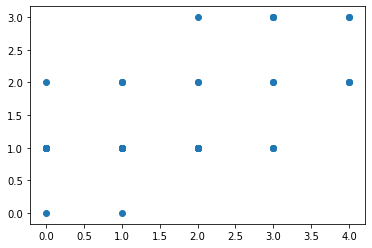

0.2845993756503643


array([1., 2., 2., 1., 3., 2., 3., 1., 1., 1., 2., 1., 3., 1., 1., 1., 1.,
       1., 2., 1., 1., 1., 1., 1., 1., 1., 2., 1., 3., 0., 1., 1., 1., 2.,
       1., 1., 1., 1., 1., 2., 0., 1., 2., 1., 1., 1., 3., 2., 3., 2.])

In [107]:
svc = SVC(kernel='rbf',degree=1,gamma='scale',coef0=-50,tol=0.01,C=5,
          shrinking=True,cache_size=50,verbose=False)
svc.fit(X_train,y_train[class_col]) 
y_pred = svc.predict(X_test)
plt.scatter(y_test[class_col],y_pred,cmap=plt.get_cmap("flag"))
plt.show()
print(r2_score(y_test[class_col],y_pred))
y_pred

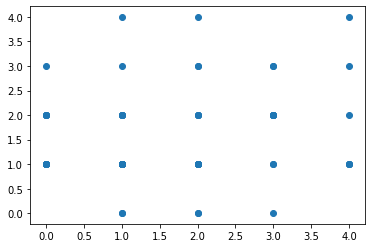

-0.35655976676384826


array([4., 1., 2., 1., 1., 2., 2., 1., 3., 1., 2., 2., 0., 1., 1., 2., 2.,
       2., 3., 1., 1., 3., 1., 2., 1., 1., 1., 2., 1., 1., 2., 3., 2., 2.,
       3., 1., 2., 1., 2., 2., 1., 1., 1., 2., 1., 1., 0., 2., 0., 0., 2.,
       1., 1., 3., 1., 4., 1., 0., 2., 1., 1., 3., 4., 2., 1., 1.])

In [108]:
y_pred = svc.predict(X_test_cls)
plt.scatter(y_test_cls[class_col],y_pred,cmap=plt.get_cmap("flag"))
plt.show()
print(r2_score(y_test_cls[class_col],y_pred))
y_pred

In [135]:
n_neighbors= 5
synthetic_data = pd.DataFrame()
for i in range(5):
    # Extract the original data in the same bin
#     y_i = y_train[y_train[class_col] == i][class_col]
#     X_i = X.loc[y_i.index]

    X_train_ = X_train.copy()
    # Fit on the original data and use it to predict the synthetic ones
    KNN = NearestNeighbors(n_neighbors = n_neighbors)
    KNN.fit(X_train)
    neighbors_index_list = KNN.kneighbors(X_train_,n_neighbors=n_neighbors)[1]
    mean_list = [np.mean(y_train.loc[y_train.iloc[neighbors_index_list[j]].index,"output"]) for j in range(len(neighbors_index_list))]    
    X_train_.loc[:,"predicted"] = mean_list

    synthetic_data = synthetic_data.append(X_train_)

In [136]:
synthetic_data = synthetic_data.drop_duplicates(keep="first").join(y_train["output"]).head()
synthetic_data

,0,1,2,3,4,5,6,7,8,9,...,1127,1128,1129,1130,1131,1132,1133,1134,predicted,output
185,1,-1,0,-1,-1,-1,1,-1,1,-1,...,1,0,1,0,-1,-1,1,-1,2.468143,1.650827
262,1,-1,-1,1,-1,-1,1,1,-1,-1,...,1,-1,-1,1,-1,-1,1,0,1.646793,1.102444
225,1,-1,0,1,1,0,1,-1,1,-1,...,1,-1,1,1,-1,-1,0,-1,2.699503,3.068568
146,1,-1,1,1,-1,-1,1,-1,-1,-1,...,1,-1,-1,1,-1,-1,1,0,1.762389,2.223774
75,-1,-1,0,1,-1,-1,1,-1,-1,-1,...,1,-1,-1,1,-1,-1,1,-1,1.561529,2.068271


In [137]:
r2_score(synthetic_data["output"],synthetic_data["predicted"])

0.2598684005419346

In [104]:
class_col = "class_kmeans"
n_neighbors= 2
X_train_cls, X_test_cls, y_train_cls, y_test_cls = train_test_split(X,y_extd,stratify=y_extd[class_col],random_state = 1)
splitted_data = []
df = pd.DataFrame([])
max_r2 = 0
for i in range(200):
    X_train, X_test, y_train, y_test = train_test_split(X_train_cls,y_train_cls,stratify=y_train_cls[class_col])
    
    knn = neighbors.KNeighborsRegressor(n_neighbors=3)
    y_pred = knn.fit(X_train, y_train["output"]).predict(X_test)
    r2_test = r2_score(y_test[class_col],y_pred)
    if r2_test > max_r2:
        splitted_data = [X_train, X_test, y_train, y_test]
        max_r2 = r2_test
#     plt.scatter(y_test["output"],y_pred,cmap=plt.get_cmap("flag"))
#     plt.show()
#     print(r2_score(y_test["output"],y_pred))
# y_pred
max_r2

0.025660119340540244

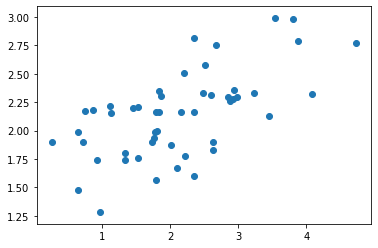

0.3308692520838742


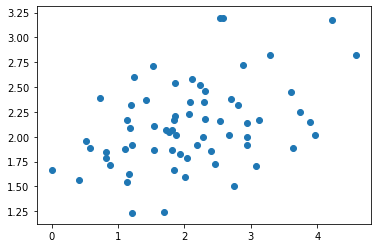

0.16425415367967566


In [77]:
svr = SVR(kernel='rbf',degree=1,gamma='scale',coef0=-50,tol=0.01,C=5,epsilon=0.1,
      shrinking=True,cache_size=50,verbose=False)
svr.fit(X_train,y_train["output"]) 
y_pred = svr.predict(X_test)
plt.scatter(y_test["output"],y_pred,cmap=plt.get_cmap("flag"))
plt.show()
print(r2_score(y_test["output"],y_pred))

y_pred = svr.predict(X_test_cls)
plt.scatter(y_test_cls["output"],y_pred,cmap=plt.get_cmap("flag"))
plt.show()
print(r2_score(y_test_cls["output"],y_pred))

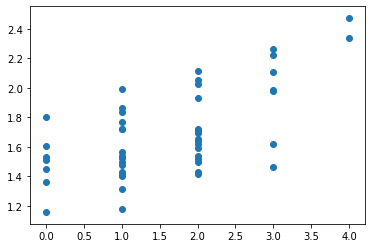

0.275272404489999


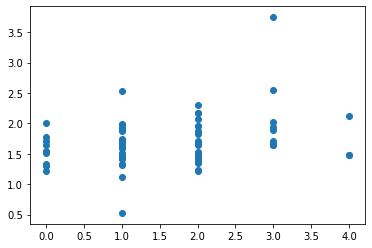

0.058039502480895844


array([2.12796277, 1.67250753, 1.3406139 , 2.17441791, 2.53837075,
       0.52486528, 1.41717007, 1.51098374, 1.64077535, 3.74890547,
       1.94468819, 1.6511807 , 2.17222068, 1.70333134, 1.61870333,
       1.36153357, 1.87546085, 2.30061379, 1.29546007, 1.42991265,
       1.92334602, 1.39001021, 1.82077152, 1.63978902, 1.59103241,
       1.66883059, 1.69512001, 1.54716901, 1.64453862, 1.74106188,
       1.71486517, 1.47429203, 1.70422299, 1.88853144, 1.47477394,
       1.43239868, 1.52139903, 1.45988448, 1.77489347, 1.95013275,
       1.21354036, 1.67605096, 1.41171706, 1.46650563, 1.3279172 ,
       1.48747373, 1.98698371, 2.07195656, 1.2163909 , 1.87688226,
       2.02997034, 1.94946066, 1.51241299, 1.23768749, 1.66638972,
       1.98048112, 2.00891937, 1.30999428, 1.117634  , 1.5062271 ,
       1.59419999, 2.54559843, 1.43630402, 1.73495957, 1.89649657,
       1.32866658])

In [68]:
sm = SMOTE()
X_res, y_res = sm.fit_resample(X_train,y_train[class_col])
# svr = SVR(kernel='rbf',degree=1,gamma='scale',coef0=-50,tol=0.01,C=5,epsilon=0.1,
#       shrinking=True,cache_size=50,verbose=False)
svc = SVC()
svr.fit(X_res,y_res) 
y_pred = svr.predict(X_test)
plt.scatter(y_test[class_col],y_pred,cmap=plt.get_cmap("flag"))
plt.show()
print(r2_score(y_test[class_col],y_pred))

y_pred = svr.predict(X_test_cls)
plt.scatter(y_test_cls[class_col],y_pred,cmap=plt.get_cmap("flag"))
plt.show()
print(r2_score(y_test_cls[class_col],y_pred))

y_pred

In [44]:
all_train = [each_data[0].join(each_data[2]["output"]) for each_data in splitted_data]
df2 = pd.DataFrame([])
for each_X_train in all_train:
    df2 = df2.append(each_X_train)
    df2 = df2[df2.duplicated(keep="first")]

df2


,0,1,2,3,4,5,6,7,8,9,...,1126,1127,1128,1129,1130,1131,1132,1133,1134,output
27,1,-1,1,1,1,1,1,-1,1,-1,...,-1,0,-1,-1,-1,1,-1,1,0,1.423992
111,1,-1,1,-1,-1,-1,-1,-1,-1,-1,...,-1,1,1,1,-1,-1,-1,1,0,2.405259
169,1,1,1,1,-1,-1,1,-1,-1,1,...,-1,1,-1,-1,-1,-1,-1,1,0,0.751181
259,1,1,0,1,-1,0,1,0,1,-1,...,-1,1,-1,0,-1,-1,-1,1,0,1.646250
117,1,1,-1,1,1,0,1,1,-1,-1,...,-1,1,-1,-1,1,1,1,1,0,1.935853
244,1,1,1,1,-1,1,1,-1,1,1,...,-1,0,-1,-1,1,-1,-1,1,0,2.274273
56,1,1,-1,1,-1,-1,1,1,1,1,...,1,1,-1,1,1,-1,-1,1,0,1.272460
91,1,-1,1,0,-1,-1,1,-1,-1,-1,...,-1,1,-1,1,1,1,-1,1,0,1.932968
163,1,-1,1,1,0,1,1,1,0,-1,...,-1,1,-1,-1,1,-1,-1,1,0,2.359755
186,1,-1,1,-1,-1,0,1,-1,1,-1,...,-1,1,-1,1,1,-1,-1,1,-1,2.075506


In [90]:
all_train_r2 = []
all_test_r2 = []
splitted_data = []
for j in range(50):
    X_train, X_test, y_train, y_test = train_test_split(X,y_extd,stratify = y_extd["class_uniform"],test_size = 0.30)
    svr = SVR(kernel='rbf',degree=1,gamma='scale',coef0=-50,tol=0.01,C=5,epsilon=0.1,
          shrinking=True,cache_size=50,verbose=False)
    svr.fit(X_train,y_train["output"])      
    y_train_pred = svr.predict(X_train)
    y_test_pred = svr.predict(X_test)
    r2_test_set = r2_score(y_test['output'],y_test_pred)
    if r2_test_set >= 0:
        all_train_r2.append(r2_score(y_train['output'],y_train_pred))
        all_test_r2.append(r2_score(y_test['output'],y_test_pred))
        splitted_data.append([X_train, X_test, y_train, y_test])
df_07 = pd.DataFrame([],columns=["test","train"])
df_07.loc[:,"test"] = all_test_r2
df_07.loc[:,"train"] = all_train_r2
df_07

,test,train
0,0.241553,0.988560
1,0.188879,0.982228
2,0.302864,0.989456
3,0.076576,0.983695
4,0.239988,0.981770
5,0.138557,0.988910
6,0.232009,0.980364
7,0.121002,0.983602
8,0.182050,0.987136
9,0.237421,0.989080


In [83]:
data_dict={}
n_neighbors = 2
iterations = 20
for class_col in ["class_quantile","class_uniform","class_kmeans"]:
    splitted_data_cls = []
    X_train_cls, X_test_cls, y_train_cls, y_test_cls = train_test_split(X,y_extd,stratify=y_extd[class_col])
    for j in range(iterations):
        # Construct synthetic dataset 
        X_train_j, X_test_j, y_train_j, y_test_j = train_test_split(X_train_cls,y_train_cls,stratify = y[class_col])
        synthetic_data_j = generate_synthetic_data(X_train_j,y_train_j,n_neighbors)
        X_syn_j = synthetic_data_j.iloc[:,:-1]
        y_syn_j = synthetic_data_j.iloc[:,-1:]
        
        # Train on train set that includes synthetic
        svr_j = SVR(kernel='rbf',degree=1,gamma='scale',coef0=-50,tol=0.01,C=5,epsilon=0.1,
              shrinking=True,cache_size=50,verbose=False)
        svr_j.fit(X_syn_j,y_syn_j) 
        
        # Find the 
        y_test_j_pred = svr.predict(X_test_j)
        r2_test_j = r2_score(y_test_j['output'],y_test_j_pred)
        if r2_test_j >= 0:
            splitted_data_cls.append([X_syn_j,y_syn_j,X_train_j, X_test_j, y_train_j, y_test_j])
    # After we 
    X_syn_cls = pd.DataFrame([])
    y_syn_cls = pd.DataFrame([])
    for i in range(len(splitted_data)):
        X_syn_cls = X_syn_cls.append(splitted_data_cls[i][0])
        y_syn_cls = y_syn_cls.append(splitted_data_cls[i][1])

    X_syn_cls.index = [i for i in range(len(X_syn_cls))]
    y_syn_cls.index = [i for i in range(len(y_syn_cls))]
    X_syn_cls = X_syn_cls.drop_duplicates(keep=False)
    y_syn_cls = y_syn_cls.loc[X_syn_cls.index]

    data_dict[class_col] = [X_syn_cls,y_syn_cls,X_train_cls, X_test_cls, y_train_cls, y_test_cls]
    

KeyError: 'class_quantile'

In [10]:
raw_data = pd.read_csv("corn_data.csv")
raw_data.head(20)

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,1126,1127,1128,1129,1130,1131,1132,1133,1134,output
0,0,1,-1,1,1,1,0,1,-1,1,...,-1,1,-1,1,1,-1,0,0,-1,2.516485
1,1,1,-1,1,1,-1,-1,1,-1,1,...,-1,1,-1,0,1,-1,-1,1,0,1.640909
2,2,0,1,1,-1,-1,-1,1,-1,-1,...,-1,1,-1,1,1,-1,-1,1,0,0.416348
3,3,1,1,1,0,-1,1,1,-1,1,...,-1,1,-1,-1,1,-1,-1,1,0,1.338558
4,4,1,1,1,0,-1,-1,1,0,1,...,-1,1,-1,0,-1,-1,1,1,0,1.729517
5,5,1,-1,1,1,-1,-1,1,-1,1,...,0,1,-1,-1,-1,-1,-1,1,0,2.704476
6,6,1,1,1,1,-1,-1,1,-1,1,...,-1,1,-1,-1,-1,1,-1,1,0,1.971622
7,7,1,1,1,0,-1,-1,1,1,1,...,-1,1,0,0,-1,-1,-1,1,0,1.843582
8,8,1,1,0,0,0,-1,1,0,1,...,-1,1,-1,0,0,-1,-1,1,1,2.082107
9,9,1,1,1,1,0,-1,1,0,1,...,-1,1,-1,0,1,-1,-1,1,0,2.898305


In [11]:
X = raw_data.iloc[:,1:-1]
y = raw_data.iloc[:,-1:]

#### Testing for KNeighbors

In [12]:
from sklearn.neighbors import NearestNeighbors

In [13]:
# n_neighbors = 7
# neigh = NearestNeighbors(n_neighbors = n_neighbors)
# neigh.fit(X)
# A = neigh.kneighbors(X,n_neighbors)
# y_neigh = np.array([[y.loc[ele,:] for ele in arr] for arr in A[1]])
# y_neigh = np.reshape(y_neigh,(len(y),n_neighbors))
# y_neigh_mean = np.mean(y_neigh, axis =1)
# a = np.where(y_neigh_mean >= 3)
# [y.iloc[i,:] for i in a]
# [y.iloc[i] for i in np.where(np.array(y)>= 3)]

#### Using discretizer

In [14]:
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import KBinsDiscretizer
from sklearn import preprocessing

In [15]:
#Strategy = Uniform
n_bins = 5
binner_qtl = KBinsDiscretizer(n_bins=n_bins, encode='ordinal',strategy='quantile')
binner_km = KBinsDiscretizer(n_bins=n_bins, encode='ordinal',strategy='kmeans')
binner_uni= KBinsDiscretizer(n_bins=n_bins, encode='ordinal',strategy='uniform')
y_b = y.copy()
y_b["class_quantile"] = binner_qtl.fit_transform(np.array(y_b["output"]).reshape(264,1))
y_b["class_kmeans"] = binner_km.fit_transform(np.array(y_b["output"]).reshape(264,1))
y_b["class_uniform"] = binner_uni.fit_transform(np.array(y_b["output"]).reshape(264,1))

uniform edges [array([0.01175325, 0.99481169, 1.97787013, 2.96092857, 3.94398701,
       4.92704545])]
kmeans edges [array([0.01175325, 1.1845431 , 1.94995124, 2.64852479, 3.48781605,
       4.92704545])]
quantile edges [array([0.01175325, 1.20853793, 1.78806113, 2.30033066, 2.93194329,
       4.92704545])]


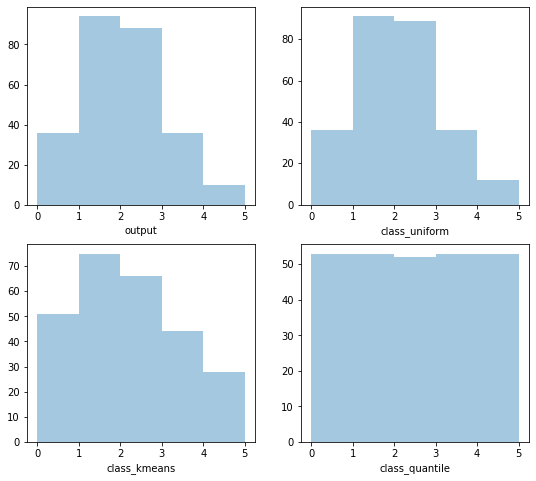

In [16]:
plt.figure(figsize=(9, 8))
plt.subplot(221)
sns.distplot(y_b["output"],bins=[0,1,2,3,4,5],hist=True,kde=False)
plt.subplot(222)
sns.distplot(y_b["class_uniform"],bins=[0,1,2,3,4,5],hist=True,kde=False)
plt.subplot(223)
sns.distplot(y_b["class_kmeans"],bins=[0,1,2,3,4,5],hist=True,kde=False)
plt.subplot(224)
sns.distplot(y_b["class_quantile"],bins=[0,1,2,3,4,5],hist=True,kde=False)
print("uniform edges" ,binner_uni.bin_edges_)
print("kmeans edges" ,binner_km.bin_edges_)
print("quantile edges" ,binner_qtl.bin_edges_)

In [17]:
y_b.head(10)

,output,class_quantile,class_kmeans,class_uniform
0,2.516485,3.0,2.0,2.0
1,1.640909,1.0,1.0,1.0
2,0.416348,0.0,0.0,0.0
3,1.338558,1.0,1.0,1.0
4,1.729517,1.0,1.0,1.0
5,2.704476,3.0,3.0,2.0
6,1.971622,2.0,2.0,1.0
7,1.843582,2.0,1.0,1.0
8,2.082107,2.0,2.0,2.0
9,2.898305,3.0,3.0,2.0


In [18]:
def make_bins(data,bin_edges):
    newList = []
    for num in data:
        i = 0;
        while i < len(bin_edges) and num >= bin_edges[i]:
            i+=1
        newNum = bin_edges[max(0,i-1)]
        newList.append(newNum)
    return newList

In [19]:
y_b.loc[:,"binned_quantile"] = make_bins(y_b["output"],binner_qtl.bin_edges_[0])
y_b.loc[:,"binned_kmeans"] = make_bins(y_b["output"],binner_km.bin_edges_[0])
y_b.loc[:,"binned_uniform"] = make_bins(y_b["output"],binner_uni.bin_edges_[0])

y_b

,output,class_quantile,class_kmeans,class_uniform,binned_quantile,binned_kmeans,binned_uniform
0,2.516485,3.0,2.0,2.0,2.300331,1.949951,1.977870
1,1.640909,1.0,1.0,1.0,1.208538,1.184543,0.994812
2,0.416348,0.0,0.0,0.0,0.011753,0.011753,0.011753
3,1.338558,1.0,1.0,1.0,1.208538,1.184543,0.994812
4,1.729517,1.0,1.0,1.0,1.208538,1.184543,0.994812
5,2.704476,3.0,3.0,2.0,2.300331,2.648525,1.977870
6,1.971622,2.0,2.0,1.0,1.788061,1.949951,0.994812
7,1.843582,2.0,1.0,1.0,1.788061,1.184543,0.994812
8,2.082107,2.0,2.0,2.0,1.788061,1.949951,1.977870
9,2.898305,3.0,3.0,2.0,2.300331,2.648525,1.977870


In [20]:
y_b["diff_quantile"] = y_b["output"]-y_b["binned_quantile"]
y_b["diff_kmeans"] = y_b["output"]-y_b["binned_kmeans"]
y_b["diff_uniform"] = y_b["output"]-y_b["binned_uniform"]

In [21]:
y_b.drop(labels=["class_quantile","class_kmeans","class_uniform"],axis=1)

,output,binned_quantile,binned_kmeans,binned_uniform,diff_quantile,diff_kmeans,diff_uniform
0,2.516485,2.300331,1.949951,1.977870,0.216155,0.566534,0.538615
1,1.640909,1.208538,1.184543,0.994812,0.432371,0.456366,0.646097
2,0.416348,0.011753,0.011753,0.011753,0.404595,0.404595,0.404595
3,1.338558,1.208538,1.184543,0.994812,0.130020,0.154015,0.343746
4,1.729517,1.208538,1.184543,0.994812,0.520979,0.544974,0.734706
5,2.704476,2.300331,2.648525,1.977870,0.404145,0.055951,0.726605
6,1.971622,1.788061,1.949951,0.994812,0.183561,0.021671,0.976810
7,1.843582,1.788061,1.184543,0.994812,0.055521,0.659039,0.848770
8,2.082107,1.788061,1.949951,1.977870,0.294046,0.132156,0.104237
9,2.898305,2.300331,2.648525,1.977870,0.597975,0.249781,0.920435


In [22]:
def find_neighbors_mean_y(X,y,X_res,n_neighbors):
    NN_obj = NearestNeighbors(n_neighbors = n_neighbors)
    NN_obj.fit(X)
    resampled_set_neighbors_list = NN_obj.kneighbors(X_res,n_neighbors)
    y_neighbors_distances = np.array(resampled_set_neighbors_list[0])
    y_neighbors = np.array([[y.loc[each_neighbor,"output"] for each_neighbor in each_data] for each_data in resampled_set_neighbors_list[1]])
    neighbors_mean_distances = np.array([np.mean(each_list) for each_list in y_neighbors_distances]).reshape(len(y_neighbors_distances),1)
    neighbors_mean_y_list = np.array([np.mean(each_list) for each_list in y_neighbors]).reshape(len(y_neighbors),1)
    return neighbors_mean_y_list, neighbors_mean_distances

mean_y, mean_dist =find_neighbors_mean_y(X,y,X,5)
y_b.loc[:,"neighbors_mean"] = mean_y
y_b.loc[:,"diff_neighbors_mean*"] = y_b["neighbors_mean"]-y_b["output"]
y_b.loc[:,"neighbors_mean_distances"] = mean_dist
a = np.array(1/(np.abs(y_b.loc[:,"diff_neighbors_mean*"])*y_b.loc[:,"neighbors_mean_distances"])).reshape(len(y_b.loc[:,"diff_neighbors_mean*"]),1)
y_b.loc[:,"neighbors_likeness_index"] = preprocessing.MinMaxScaler().fit_transform(a)

y_b.drop(columns = ["binned_quantile","binned_kmeans","binned_uniform","diff_quantile","diff_kmeans","diff_uniform"] )

,output,class_quantile,class_kmeans,class_uniform,neighbors_mean,diff_neighbors_mean*,neighbors_mean_distances,neighbors_likeness_index
0,2.516485,3.0,2.0,2.0,2.599369,0.082884,7.591294,0.139012
1,1.640909,1.0,1.0,1.0,1.701757,0.060848,24.859739,0.056815
2,0.416348,0.0,0.0,0.0,1.910787,1.494439,25.238024,0.000623
3,1.338558,1.0,1.0,1.0,2.160018,0.821460,26.294076,0.002375
4,1.729517,1.0,1.0,1.0,2.049377,0.319860,24.340390,0.009649
5,2.704476,3.0,3.0,2.0,2.719939,0.015463,23.015278,0.247091
6,1.971622,2.0,2.0,1.0,2.537954,0.566332,24.906923,0.004553
7,1.843582,2.0,1.0,1.0,2.523708,0.680126,22.952897,0.003947
8,2.082107,2.0,2.0,2.0,2.186747,0.104639,22.311837,0.036203
9,2.898305,3.0,3.0,2.0,2.856576,-0.041729,23.101301,0.090133


In [23]:
stat_df = pd.DataFrame(columns = ["diff_quantile","diff_kmeans","diff_uniform"])
stat_df = stat_df.append(pd.Series([np.median(y_b["diff_quantile"]),np.median(y_b["diff_kmeans"]),
                          np.median(y_b["diff_uniform"]),np.median(y_b["diff_neighbors_mean*"])],
                       index=["diff_quantile","diff_kmeans","diff_uniform","diff_neighbors_mean*"],name = "median"))
stat_df = stat_df.append(pd.Series([np.var(y_b["diff_quantile"]),np.var(y_b["diff_kmeans"]),
                          np.var(y_b["diff_uniform"]),np.var(y_b["diff_neighbors_mean*"])],index=["diff_quantile","diff_kmeans","diff_uniform","diff_neighbors_mean*"],
                         name = "var"))
stat_df = stat_df.append(pd.Series([np.mean(y_b["diff_quantile"]),np.mean(y_b["diff_kmeans"]),
                          np.mean(y_b["diff_uniform"]),np.mean(y_b["diff_neighbors_mean*"])],index=["diff_quantile","diff_kmeans","diff_uniform","diff_neighbors_mean*"],
                         name = "mean"))
stat_df = stat_df.append(pd.Series([np.std(y_b["diff_quantile"]),np.std(y_b["diff_kmeans"]),
                          np.std(y_b["diff_uniform"]),np.std(y_b["diff_neighbors_mean*"])],index=["diff_quantile","diff_kmeans","diff_uniform","diff_neighbors_mean*"],
                         name = "std"))
stat_df

,diff_quantile,diff_kmeans,diff_uniform,diff_neighbors_mean*
median,0.351980,0.426716,0.533906,0.259856
var,0.134586,0.088834,0.087586,0.566238
mean,0.442396,0.454480,0.499496,0.208158
std,0.366859,0.298050,0.295949,0.752488


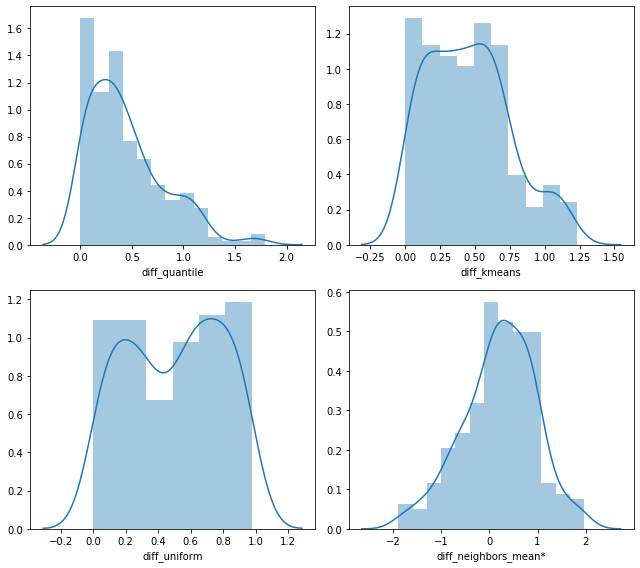

In [24]:
plt.figure(figsize=(9, 8))
plt.subplot(221)
sns.distplot(y_b["diff_quantile"],hist=True,kde=True)
plt.subplot(222)
sns.distplot(y_b["diff_kmeans"],hist=True,kde=True)
plt.subplot(223)
sns.distplot(y_b["diff_uniform"],hist=True,kde=True)
plt.subplot(224)
sns.distplot(y_b["diff_neighbors_mean*"],hist=True,kde=True)
plt.tight_layout()


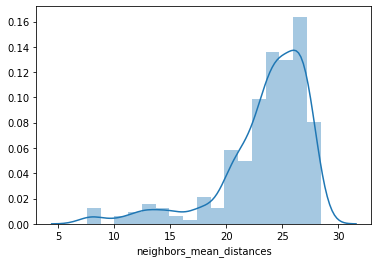

In [25]:
sns.distplot(y_b["neighbors_mean_distances"],hist=True,kde=True)


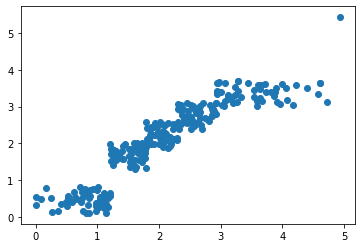

diff_quantile 0.824868883698948


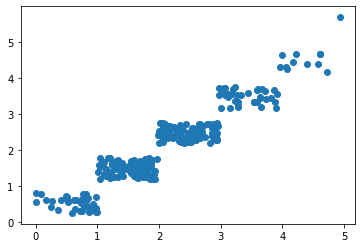

diff_uniform 0.8702823661725265


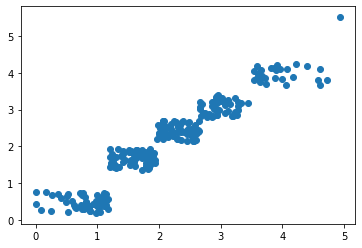

diff_kmeans 0.879050077683673


In [26]:
for name in ["quantile","uniform","kmeans"]:
    diff = "diff_"+name
    binned_data = y_b.loc[:,"binned_"+name]
    mean = stat_df.loc["mean",diff]
    std = stat_df.loc["std",diff]
    adjusted = [each_data + (mean - std + 2*std*random()) for each_data in binned_data]
    plt.scatter(y_b["output"],adjusted,cmap=plt.get_cmap("flag"))
    plt.show()
    print(diff,r2_score(y_b["output"],adjusted))

#### Adjusting data based on same bin neighbor

In [32]:
n_neighbors = 3
for class_col in ["class_quantile","class_uniform","class_kmeans"]:
    all_train_r2 = []
    all_test_r2 = []
    for j in range(10):
        X_train, X_test, y_train, y_test = train_test_split(X,y_b,stratify = y_b[class_col])

        sm = SMOTE()
        X_res, y_res = sm.fit_resample(X_train,y_train[class_col])

        synthetic_data = pd.DataFrame()
        for i in range(5):
            y_i = y_train[y_train[class_col]==i]
            X_i = X_train.loc[y_i.index]
            X_res_i = X_res.loc[pd.Series.where(y_res,y_res==i).dropna().index]
            KNN = NearestNeighbors(n_neighbors = n_neighbors)
            KNN.fit(X_i)

            X_resampled_same_bin_neighbors_list = KNN.kneighbors(X_res_i,n_neighbors=n_neighbors)
            y_neighbors_distances = np.array(X_resampled_same_bin_neighbors_list[0])
            y_train_index = [[y_i.index[i] for i in each_data] for each_data in X_resampled_same_bin_neighbors_list[1]]
            y_neighbors = np.array([[y_i.loc[each_neighbor,"output"] for each_neighbor in each_data] for each_data in y_train_index])
            neighbors_mean_distances = np.array([np.mean(each_list) for each_list in y_neighbors_distances]).reshape(len(y_neighbors_distances),1)
            neighbors_mean_y_list = np.array([np.mean(each_list) for each_list in y_neighbors]).reshape(len(y_neighbors),1)
            X_res_i.loc[:,"output"]=neighbors_mean_y_list
            synthetic_data = synthetic_data.append(X_res_i)

        X_syn = synthetic_data.iloc[:,:-1].append(X_train)
        y_syn = synthetic_data.iloc[:,-1:].append(y_train)["output"]
        

        svr = SVR(kernel='rbf',degree=1,gamma='scale',coef0=-50,tol=0.01,C=5,epsilon=0.1,
                  shrinking=True,cache_size=50,verbose=False)
        svr.fit(X_syn,y_syn)      
        y_train_pred = svr.predict(X_train)
        y_test_pred = svr.predict(X_test)
        all_train_r2.append(r2_score(y_train['output'],y_train_pred))
        all_test_r2.append(r2_score(y_test['output'],y_test_pred))

    print(class_col+"_train",np.mean(all_train_r2))
    print(class_col+"_test",np.mean(all_test_r2))

class_quantile_train 0.9729471431637091
class_quantile_test 0.13865509949474444
class_uniform_train 0.9797909441605664
class_uniform_test 0.20362769238095818
class_kmeans_train 0.9812175628524354
class_kmeans_test 0.21881997915559487


In [154]:
svr = SVR(kernel='rbf',degree=1,gamma='scale',coef0=-50,tol=0.01,C=5,epsilon=0.1,
          shrinking=True,cache_size=50,verbose=False)
svr.fit(X_syn,y_syn)      
y_train_pred = svr.predict(X_train)
y_test_pred = svr.predict(X_test)
print(r2_score(y_train['output'],y_train_pred))
print(r2_score(y_test['output'],y_test_pred))


0.921889049989361
0.2194952767744086


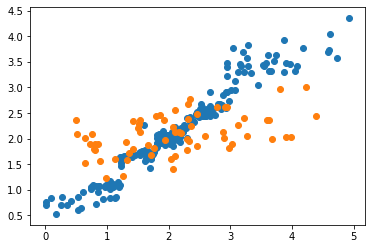

In [155]:
plt.scatter(y_train["output"],y_train_pred,cmap=plt.get_cmap("flag"))
plt.scatter(y_test["output"],y_test_pred,cmap=plt.get_cmap("flag"))

plt.show()

In [ ]:
n_neighbors_list = [1,2,3]#,4,5,6,7,8,9,10]

strategies = ["uniform", "quantile", "kmeans"]
# columns = [binning_strategy+set for set in ["_test"] for binning_strategy in strategies]
df_mean = pd.DataFrame(columns = strategies)
df = pd.DataFrame()

for n_neighbors in n_neighbors_list: 

    for binning_strategy in strategies:
        all_train_r2 = []
        all_test_r2 = []

    #   Discretizing/Binning the data
        binner = KBinsDiscretizer(n_bins=5, encode='ordinal',strategy=binning_strategy)
        y_b = y.copy()
        y_b[binning_strategy] = binner.fit_transform(np.array(y_b["output"]).reshape(264,1))

        for i in range(2):
    #       Use the binned data for stratification and for resampling
            sm = SMOTE()
            X_train, X_test, y_train, y_test = train_test_split(X,y_b,stratify=y_b[binning_strategy])
            X_res_km, y_res_km = sm.fit_resample(X_train,y_train[binning_strategy])

    #       Adjust the value after resampling
            y_res_df = pd.DataFrame(y_res_km)
                                                # Find the mean y of neighbors for all datapoints in X_res
            y_res_df.loc[:,"n_neighbor_means"] = find_neighbors_mean_y(X,y,X_res_km,n_neighbors=5)
            y_res_df.loc[:,"adjusted value"] = (y_res_df[binning_strategy] + y_res_df.loc[:,"n_neighbor_means"])/2

    #       Feed the adjusted resampled set into SVR for prediction
            svr = SVR(kernel='rbf',degree=1,gamma='scale',coef0=-50,tol=0.01,C=5,epsilon=0.1,
                      shrinking=True,cache_size=50,verbose=False)
            svr.fit(X_res_km,y_res_df["adjusted value"])      
#             y_train_pred = svr.predict(X_train)
#             all_train_r2.append(r2_score(y_train['output'],y_train_pred))
            y_test_pred = svr.predict(X_test)
            r2_test_set = r2_score(y_test['output'],y_test_pred)
            all_test_r2.append(r2_test_set)
            df = df.append(pd.Series([n_neighbors,binning_strategy,r2_test_set],index=["n_neighbors","binning_strategy","r2_test_set"],name=binning_strategy+"@"+str(n_neighbors)+"#"+str(i)),)
            
#         df.loc[n_neighbors,binning_strategy+"_train"] = np.mean(all_train_r2)
        df_mean.loc[n_neighbors,binning_strategy] = np.mean(all_test_r2)

df

In [ ]:
from random import random

In [28]:
lr.coef_

array([-0.24305338])

In [ ]:
# sm = SMOTE()
# X_res_km, y_res_km = sm.fit_resample(X_train,y_train["binned_kmeans"])
# X_res_uni, y_res_uni = sm.fit_resample(X_train,y_train["binned_uniform"])
# X_res_qtl, y_res_qtl = sm.fit_resample(X_train,y_train["binned_quantile"])


In [ ]:
n_neighbors = 5
neigh = NearestNeighbors(n_neighbors = n_neighbors)
neigh.fit(X)
res_neighbors_list = neigh.kneighbors(X_res_km,n_neighbors)
res_neighbors_list

In [27]:
from sklearn.linear_model import LinearRegression, RidgeCV,RANSACRegressor,Lars, BayesianRidge, ARDRegression,PassiveAggressiveRegressor
rows = ["diff_quantile","diff_kmeans","diff_uniform","diff_neighbors_mean*"]
funcs = [LinearRegression,RidgeCV,RANSACRegressor,Lars, BayesianRidge,ARDRegression,PassiveAggressiveRegressor]
df = pd.DataFrame()
for func in funcs:
    for row in rows:
        lr = func()
        X2 = np.array(y_b[row]).reshape(len(y_b),1)
        y2 = np.array(y_b["neighbors_likeness_index"]).reshape(len(y_b),1)
        lr.fit(y2,X2)
        df.loc[row,str(func)]=lr.score(y2,X2)
df

,<class 'sklearn.linear_model._base.LinearRegression'>,<class 'sklearn.linear_model._ridge.RidgeCV'>,<class 'sklearn.linear_model._ransac.RANSACRegressor'>,<class 'sklearn.linear_model._least_angle.Lars'>,<class 'sklearn.linear_model._bayes.BayesianRidge'>,<class 'sklearn.linear_model._bayes.ARDRegression'>,<class 'sklearn.linear_model._passive_aggressive.PassiveAggressiveRegressor'>
diff_quantile,0.017145,0.014109,-11.285876,0.017145,0.016331,0.016331,-0.634668
diff_kmeans,0.011336,0.011284,0.004428,0.011336,0.010092,0.010092,-0.565583
diff_uniform,0.000193,0.000044,-9.129031,0.000193,0.000001,0.000001,-0.615851
diff_neighbors_mean*,0.004583,0.003771,-15.836147,0.004583,0.001497,0.001497,-0.019154


In [ ]:
len(X_res_km)

In [ ]:
y_neigh = np.array([[y.loc[neigh,"output"] for neigh in each_data] for each_data in res_neighbors_list[1]])


In [ ]:
y_neighbor_mean = np.array([np.mean(ele) for ele in y_neigh]).reshape(len(y_neigh),1)

In [ ]:
y_res_df["kneighbor_means"] =y_neighbor_mean
y_res_df["adjusted value"] = (y_res_df["binned_kmeans"] + y_res_df["kneighbor_means"])/2
y_res_df

In [ ]:
X1 = [1,1.1,1.2,1.2,1.99,2,2.3,2.5,2.9,3.9,4.0,4.1,4.6,4.7,4.9,4.99,4.999,10]
X1 = np.reshape(sorted(X1),(len(X1),1))*-1
est1 = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='kmeans')
est2 = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='uniform')
est3 = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='quantile')

est1.fit(X1)
est2.fit(X1)
est3.fit(X1)

Xt1 = est1.transform(X1)
Xt2 = est2.transform(X1)
Xt3 = est3.transform(X1)

df_ = pd.DataFrame(columns=["org","kmeans","uniform","quantile"])
print(est1.bin_edges_)
[(a,b,c,d) for (a,b,c,d) in zip(X1,Xt1,Xt2,Xt3) ]# doctest: +SKIP
for (a,b,c,d) in zip(X1,Xt1,Xt2,Xt3):
    df_ = df_.append(pd.Series((a,b,c,d),index=["org","kmeans","uniform","quantile"],name="series"))
df_

In [ ]:
def find_neighbors_mean_y(X,y,X_res,n_neighbors):
    NN_obj = NearestNeighbors(n_neighbors = n_neighbors)
    NN_obj.fit(X)
    resampled_set_neighbors_list = NN_obj.kneighbors(X_res,n_neighbors)
    y_neighbors = np.array([[y.loc[each_neighbor,"output"] for each_neighbor in each_data] for each_data in resampled_set_neighbors_list[1]])
    neighbors_mean_y_list = np.array([np.mean(each_list) for each_list in y_neighbors]).reshape(len(y_neighbors),1)
    return neighbors_mean_y_list

strategies = ["uniform", "quantile", "kmeans"]
for binning_strategy in strategies:
    all_train_r2 = []
    all_test_r2 = []
    
#   Discretizing/Binning the data
    binner = KBinsDiscretizer(n_bins=5, encode='ordinal',strategy=binning_strategy)
    y_b = y.copy()
    y_b[binning_strategy] = binner.fit_transform(np.array(y_b["output"]).reshape(264,1))

    for i in range(50):
#       Use the binned data for stratification and for resampling
        sm = SMOTE()
        X_train, X_test, y_train, y_test = train_test_split(X,y_b,stratify=y_b[binning_strategy])
        X_res_km, y_res_km = sm.fit_resample(X_train,y_train[binning_strategy])
        
#       Adjust the value after resampling
        y_res_df = pd.DataFrame(y_res_km)
                                            # Find the mean y of neighbors for all datapoints in X_res
        y_res_df.loc[:,"kneighbor_means"] = find_neighbors_mean_y(X,y,X_res_km,n_neighbors=5)
        y_res_df.loc[:,"adjusted value"] = (y_res_df[binning_strategy] + y_res_df.loc[:,"kneighbor_means"])/2
        
#       Feed the adjusted resampled set into SVR for prediction
        svr = SVR(kernel='rbf',degree=1,gamma='scale',coef0=-50,tol=0.01,C=5,epsilon=0.1,
                  shrinking=True,cache_size=50,verbose=False)
        svr.fit(X_res_km,y_res_df["adjusted value"])      
        y_train_pred = svr.predict(X_train)
        y_test_pred = svr.predict(X_test)
        all_train_r2.append(r2_score(y_train['output'],y_train_pred))
        all_test_r2.append(r2_score(y_test['output'],y_test_pred))

    print(binning_strategy+"_train",np.mean(all_train_r2))
    print(binning_strategy+"_test",np.mean(all_test_r2))

In [ ]:
n_neighbors_list = [1,2,3,4,5,6,7,8,9,10]

strategies = ["uniform", "quantile", "kmeans"]
columns = [binning_strategy+set for set in ["_test"] for binning_strategy in strategies]
df_mean = pd.DataFrame(columns = columns)
df = pd.DataFrame()

for n_neighbors in n_neighbors_list: 

    for binning_strategy in strategies:
        all_train_r2 = []
        all_test_r2 = []

    #   Discretizing/Binning the data
        binner = KBinsDiscretizer(n_bins=5, encode='ordinal',strategy=binning_strategy)
        y_b = y.copy()
        y_b[binning_strategy] = binner.fit_transform(np.array(y_b["output"]).reshape(264,1))

        for i in range(20):
    #       Use the binned data for stratification and for resampling
            sm = SMOTE()
            X_train, X_test, y_train, y_test = train_test_split(X,y_b,stratify=y_b[binning_strategy])
            X_res_km, y_res_km = sm.fit_resample(X_train,y_train[binning_strategy])

    #       Adjust the value after resampling
            y_res_df = pd.DataFrame(y_res_km)
                                                # Find the mean y of neighbors for all datapoints in X_res
            y_res_df.loc[:,"n_neighbor_means"] = find_neighbors_mean_y(X,y,X_res_km,n_neighbors=5)
            y_res_df.loc[:,"adjusted value"] = (y_res_df[binning_strategy] + y_res_df.loc[:,"n_neighbor_means"])/2

    #       Feed the adjusted resampled set into SVR for prediction
            svr = SVR(kernel='rbf',degree=1,gamma='scale',coef0=-50,tol=0.01,C=5,epsilon=0.1,
                      shrinking=True,cache_size=50,verbose=False)
            svr.fit(X_res_km,y_res_df["adjusted value"])      
#             y_train_pred = svr.predict(X_train)
#             all_train_r2.append(r2_score(y_train['output'],y_train_pred))
            y_test_pred = svr.predict(X_test)
            r2_test_set = r2_score(y_test['output'],y_test_pred)
            all_test_r2.append(r2_test_set)
            df = df.append(pd.Series([n_neighbors,binning_strategy,r2_test_set],index=["n_neighbors","binning_strategy","r2_test_set"],name=binning_strategy+"@"+str(n_neighbors)+"#"+str(i)),)
            
#         df.loc[n_neighbors,binning_strategy+"_train"] = np.mean(all_train_r2)
        df_mean.loc[n_neighbors,binning_strategy] = np.mean(all_test_r2)

df

In [ ]:
df[df["binning_strategy"]=="uniform"][df["n_neighbors"]==1]
# df.filter(items=["binning_strategies","n_neighbors"])

In [ ]:
for col in strategies:
    sns.catplot(x="n_neighbors",y="r2_test_set",data=df[df["binning_strategy"]==col],palette="icefire",kind="point",aspect=1.7)
    plt.title(col)


In [ ]:
columns = [binning_strategy+set for set in ["_train","_test"] for binning_strategy in strategies]
for col in ["uniform_test","quantile_test","kmeans_test"]:
    sns.catplot(x=df.index,y=col,data=df,palette="icefire",kind="point",aspect=1.7)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y,stratify=y['binned_kmeans'])
sns.distplot(y_train["output"],bins=[0,1,2,3,4,5],hist=True,kde=True)
sns.distplot(y_test["output"],bins=[0,1,2,3,4,5],hist=True,kde=True)

In [ ]:
svr.fit(X_res_km,y_res_df["adjusted value"])
y_train_pred = svr.predict(X_train)
y_test_pred = svr.predict(X_test)
print(r2_score(y_train['output'],y_train_pred))
print(r2_score(y_test['output'],y_test_pred))
y_res

In [ ]:
svr.fit(X_res_km,y_res_km)
y_train_pred = svr.predict(X_train)
y_test_pred = svr.predict(X_test)
y_test

In [ ]:
print(r2_score(y_train['output'],y_train_pred))
print(r2_score(y_test['output'],y_test_pred))


In [ ]:
def scatterplot(name,x,x_label,y,y_label,fit_reg,color):
    df1 = pd.DataFrame({x_label:x,y_label:y})
    plt.title(name)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    sns.regplot(data=df1,x=x_label,y=y_label,fit_reg=fit_reg,color=color)

In [ ]:
scatterplot("SVR", np.array(y_train['output']),"Actual values",np.array(y_train_pred).ravel(),"Predicted values",True,None)
scatterplot("SVR", np.array(y_test['output']),"Actual values",np.array(y_test_pred).ravel(),"Predicted values",True,None)


#### Distinguishing synthetic Data

In [ ]:
# X_train, X_test, y_train, y_test = train_test_split(X,y_trunc)
# X_train.head()
# y_train

In [ ]:
# sm = SMOTE()
# X_res,y_res = sm.fit_resample(X_train,y_train)
# X_res.head(15)
# y_res

In [ ]:
print(X_train.shape, X_test.shape, X_res.shape)

In [ ]:
df_res = X_res
df_res.loc[:,'truncated'] = y_res

df_train = X_train
df_train.loc[:,'truncated'] = y_train

df_test = X_test
df_test.loc[:,'truncated'] = y_test

# Having output has no bearing on the removal of duplicates

df_syn = df_res.append(df_train).drop_duplicates()

In [ ]:
# df_syn
# X_syn = df_syn.iloc[:,:-1]
# y_syn = df_syn.iloc[:,-1:]

In [ ]:
from sklearn.neighbors import KNeighborsRegressor

all_train_r2 = []
all_test_r2 = []

for i in range(20):
    knr = KNeighborsRegressor(n_neighbors = 5)
    X_train, X_test, y_train, y_test = train_test_split(X,y_b)
    knr.fit(X_train,y_train["output"])
    y_train_pred = knr.predict(X_train)
    y_test_pred = knr.predict(X_test)
    all_train_r2.append(r2_score(y_train['output'],y_train_pred))
    all_test_r2.append(r2_score(y_test['output'],y_test_pred))

print("train",np.mean(all_train_r2))
print("test",np.mean(all_test_r2))

In [ ]:
clf = SVR()
X_train.iloc[:,:-1]
clf.fit(X_train.iloc[:,:-1],y_train.iloc[:,-1:])
y_train_predicted = clf.predict(X_train.iloc[:,:-1])
y_test_predicted  = clf.predict(X_test.iloc[:,:-1])
y_syn_predicted = clf.predict(X_syn)

In [ ]:
plt.scatter(y_train,y_train_predicted)
plt.scatter(y_test,y_test_predicted)
plt.scatter(y_syn,y_syn_predicted)

In [ ]:
y_res

#### make_bins() funct

In [ ]:
def make_bins(data,bin_edges):
    newList = []
    for num in data:
        i = 0;
        while i < len(bin_edges) and num >= bin_edges[i]:
            i+=1
        newNum = bin_edges[max(0,i-1)]
        newList.append(newNum)
    return newList

In [ ]:
from random import randint
list = [randint(1,10) for i in range(10)]
list

In [ ]:
bins = np.linspace(0,10,11,dtype="int")
list2 = make_bins(list,bins)

In [ ]:
list2 #Nothing special yet

In [ ]:
bins3 = [0,1,2,7,8]
list3 = make_bins(list,bins3)
list3

In [ ]:
#### 

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X,y_b,stratify = y_b['class_quantile'])
y_train.head()

,output,class_quantile,class_kmeans,class_uniform,binned_quantile,binned_kmeans,binned_uniform,diff_quantile,diff_kmeans,diff_uniform,neighbors_mean,diff_neighbors_mean*,neighbors_mean_distances,neighbors_likeness_index
183,1.905936,2.0,1.0,1.0,1.788061,1.184543,0.994812,0.117875,0.721393,0.911125,2.486154,0.580217,23.564106,0.004752
66,2.640817,3.0,2.0,2.0,2.300331,1.949951,1.977870,0.340486,0.690866,0.662947,2.416525,-0.224291,27.010132,0.012892
254,1.541920,1.0,1.0,1.0,1.208538,1.184543,0.994812,0.333382,0.357377,0.547108,2.386130,0.844210,23.954302,0.002654
258,0.775103,0.0,0.0,0.0,0.011753,0.011753,0.011753,0.763349,0.763349,0.763349,1.953517,1.178414,24.763091,0.001309
17,3.286233,4.0,3.0,3.0,2.931943,2.648525,2.960929,0.354289,0.637708,0.325304,2.422979,-0.863253,23.892930,0.002568


In [28]:
sm = SMOTE()
X_res, y_res = sm.fit_resample(X_train,y_train['class_quantile'])
y_res


0      2.0
1      3.0
2      1.0
3      0.0
4      4.0
5      4.0
6      4.0
7      3.0
8      0.0
9      4.0
10     2.0
11     1.0
12     3.0
13     3.0
14     2.0
15     3.0
16     2.0
17     1.0
18     3.0
19     4.0
20     4.0
21     4.0
22     3.0
23     3.0
24     4.0
25     0.0
26     2.0
27     1.0
28     1.0
29     1.0
      ... 
170    1.0
171    0.0
172    1.0
173    2.0
174    3.0
175    1.0
176    0.0
177    2.0
178    1.0
179    1.0
180    3.0
181    1.0
182    3.0
183    1.0
184    2.0
185    3.0
186    1.0
187    0.0
188    0.0
189    3.0
190    2.0
191    3.0
192    1.0
193    4.0
194    1.0
195    0.0
196    1.0
197    4.0
198    1.0
199    2.0
Name: class_quantile, Length: 200, dtype: float64

In [29]:
synthetic_data = pd.DataFrame()
for i in range(5):
    y_i = y_train[y_train['class_quantile']==i]
    X_i = X_train.loc[y_i.index]
    X_res_i = X_res.loc[pd.Series.where(y_res,y_res==i).dropna().index]
    KNN = NearestNeighbors(n_neighbors = 3)
    KNN.fit(X_i)

    X_resampled_same_bin_neighbors_list = KNN.kneighbors(X_res_i,n_neighbors=3)
    y_neighbors_distances = np.array(X_resampled_same_bin_neighbors_list[0])
    y_train_index = [[y_i.index[i] for i in each_data] for each_data in X_resampled_same_bin_neighbors_list[1]]
    y_neighbors = np.array([[y_i.loc[each_neighbor,"output"] for each_neighbor in each_data] for each_data in y_train_index])
    neighbors_mean_distances = np.array([np.mean(each_list) for each_list in y_neighbors_distances]).reshape(len(y_neighbors_distances),1)
    neighbors_mean_y_list = np.array([np.mean(each_list) for each_list in y_neighbors]).reshape(len(y_neighbors),1)
    X_res_i.loc[:,"output"]=neighbors_mean_y_list
    synthetic_data = synthetic_data.append(X_res_i)

synthetic_data


,0,1,2,3,4,5,6,7,8,9,...,1126,1127,1128,1129,1130,1131,1132,1133,1134,output
3,1,1,1,1,-1,-1,1,-1,1,-1,...,-1,1,-1,1,1,-1,-1,1,0,0.897273
8,1,1,1,0,-1,-1,1,-1,1,-1,...,-1,1,-1,1,-1,-1,-1,1,0,0.904541
25,1,-1,0,-1,-1,1,-1,1,-1,-1,...,-1,1,-1,1,-1,-1,-1,1,0,0.640240
33,1,1,1,0,-1,0,1,-1,1,-1,...,-1,1,-1,-1,1,-1,-1,1,0,0.744325
37,1,1,-1,1,-1,1,1,-1,0,-1,...,-1,1,-1,-1,1,-1,1,1,0,0.994443
38,1,-1,1,1,-1,-1,1,1,1,1,...,-1,1,-1,1,-1,-1,-1,1,0,0.939868
39,1,1,1,1,-1,-1,1,1,-1,-1,...,-1,1,0,-1,1,-1,-1,1,0,0.984287
43,1,-1,-1,-1,-1,-1,1,-1,-1,-1,...,-1,1,-1,-1,1,-1,-1,-1,0,0.662499
47,0,1,1,1,-1,-1,1,-1,-1,-1,...,-1,1,-1,1,1,-1,-1,1,0,1.066109
49,1,-1,1,1,1,-1,1,1,1,1,...,-1,1,-1,-1,1,1,-1,1,0,0.637250


In [30]:
X_syn = synthetic_data.iloc[:,:-1]
y_syn = synthetic_data.iloc[:,-1:]
X_syn.append(X_train)
y_syn.append(y_train)["output"]

3      0.897273
8      0.904541
25     0.640240
33     0.744325
37     0.994443
38     0.939868
39     0.984287
43     0.662499
47     1.066109
49     0.637250
69     0.873727
77     0.984287
80     0.965484
86     0.718905
89     1.060642
92     0.805552
94     0.949465
98     0.955132
101    0.857743
105    0.753154
111    0.501994
113    1.018651
117    0.904541
118    0.724757
120    0.955132
124    1.031728
126    0.995208
132    0.597845
140    0.972184
143    0.709227
         ...   
144    3.125277
214    3.010972
64     1.352334
257    1.042270
205    1.331315
115    1.870672
167    2.352652
67     1.721248
247    1.176624
164    1.814852
252    1.529263
213    1.765849
201    2.828678
61     1.659274
229    2.582644
143    1.226839
170    2.242296
15     2.629321
250    1.507630
256    0.977090
199    0.526591
151    2.667092
221    2.057771
149    2.542820
113    1.455943
14     2.945429
200    1.264815
207    0.814634
224    1.721297
171    3.228499
Name: output, Length: 39